<a href="https://colab.research.google.com/github/XTWLP/CNN/blob/master/pytorch/Captum_Recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Model Interpretability using Captum
===================================




Captum helps you understand how the data features impact your model
predictions or neuron activations, shedding light on how your model
operates.

Using Captum, you can apply a wide range of state-of-the-art feature
attribution algorithms such as \ ``Guided GradCam``\  and
\ ``Integrated Gradients``\  in a unified way.

In this recipe you will learn how to use Captum to: \* attribute the
predictions of an image classifier to their corresponding image
features. \* visualize the attribution results.




Before you begin
----------------




Make sure Captum is installed in your active Python environment. Captum
is available both on GitHub, as a ``pip`` package, or as a ``conda``
package. For detailed instructions, consult the installation guide at
https://captum.ai/




For a model, we use a built-in image classifier in PyTorch. Captum can
reveal which parts of a sample image support certain predictions made by
the model.




In [ ]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

model = torchvision.models.resnet18(pretrained=True).eval()

response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel rgb distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])
input_img = normalize(center_crop(img)).unsqueeze(0)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Computing Attribution
---------------------




Among the top-3 predictions of the models are classes 208 and 283 which
correspond to dog and cat.

Let us attribute each of these predictions to the corresponding part of
the input, using Captum’s \ ``Occlusion``\  algorithm.




In [ ]:
!pip install captum

     |████████████████████████████████| 5.7MB 3.8MB/s 


In [ ]:
from captum.attr import Occlusion 

occlusion = Occlusion(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=208,                       # Labrador index in ImageNet 
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,                       # Persian cat index in ImageNet 
attribution_cat = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

Besides ``Occlusion``, Captum features many algorithms such as
\ ``Integrated Gradients``\ , \ ``Deconvolution``\ ,
\ ``GuidedBackprop``\ , \ ``Guided GradCam``\ , \ ``DeepLift``\ , and
\ ``GradientShap``\ . All of these algorithms are subclasses of
``Attribution`` which expects your model as a callable ``forward_func``
upon initialization and has an ``attribute(...)`` method which returns
the attribution result in a unified format.

Let us visualize the computed attribution results in case of images.




Visualizing the Results
-----------------------




Captum’s \ ``visualization``\  utility provides out-of-the-box methods
to visualize attribution results both for pictorial and for textual
inputs.




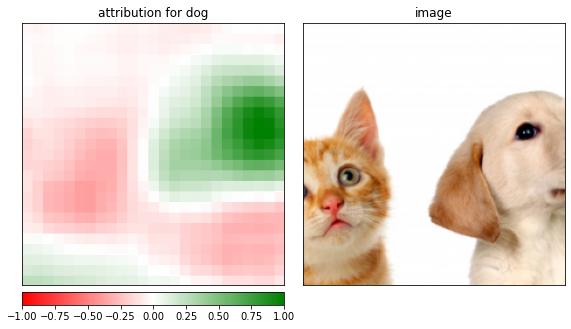

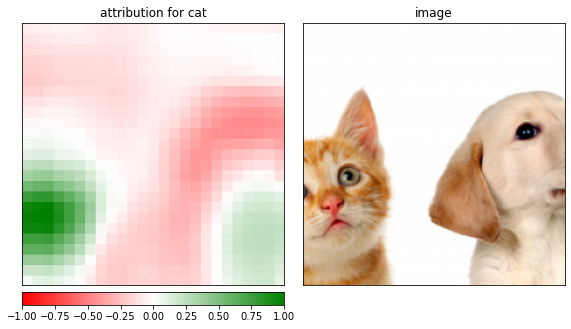

In [ ]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )


attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],  
                                      ["all", "all"], # positive/negative attribution or all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )

If your data is textual, ``visualization.visualize_text()`` offers a
dedicated view to explore attribution on top of the input text. Find out
more at http://captum.ai/tutorials/IMDB_TorchText_Interpret




Final Notes
-----------




Captum can handle most model types in PyTorch across modalities
including vision, text, and more. With Captum you can: \* Attribute a
specific output to the model input as illustrated above. \* Attribute a
specific output to a hidden-layer neuron (see Captum API reference). \*
Attribute a hidden-layer neuron response to the model input (see Captum
API reference).

For complete API of the supported methods and a list of tutorials,
consult our website http://captum.ai

Another useful post by Gilbert Tanner:
https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

